<a href="https://colab.research.google.com/github/basilpaul7/Bi-Directional-Braille-Communication/blob/main/Braille_Text_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
from shutil import copyfile

In [3]:
os.mkdir('./images/')
alpha = 'a'
for i in range(0, 26): 
    os.mkdir('./images/' + alpha)
    alpha = chr(ord(alpha) + 1)

rootdir = '/content/drive/MyDrive/Personal/Main Project/Braille Dataset/'
for file in os.listdir(rootdir):
    letter = file[0]
    copyfile(rootdir+file, './images/' + letter + '/' + file)

In [4]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('./images/',
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory('./images/',
                                            target_size=(28,28),
                                            subset='validation')

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [5]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=666,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

Epoch 1/666


<ipython-input-5-709140038fe6>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


39/39 [==============================] - 11s 56ms/step - loss: 3.2763 - accuracy: 0.0337 - val_loss: 3.1998 - val_accuracy: 0.0449 - lr: 0.0010
Epoch 2/666
39/39 [==============================] - 1s 33ms/step - loss: 3.0590 - accuracy: 0.1042 - val_loss: 2.7784 - val_accuracy: 0.1603 - lr: 0.0010
Epoch 3/666
39/39 [==============================] - 1s 33ms/step - loss: 2.5548 - accuracy: 0.2252 - val_loss: 2.2125 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 4/666
39/39 [==============================] - 1s 32ms/step - loss: 1.9689 - accuracy: 0.4046 - val_loss: 1.6020 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 5/666
39/39 [==============================] - 1s 32ms/step - loss: 1.5578 - accuracy: 0.5337 - val_loss: 1.4077 - val_accuracy: 0.6090 - lr: 0.0010
Epoch 6/666
39/39 [==============================] - 1s 32ms/step - loss: 1.2345 - accuracy: 0.6490 - val_loss: 1.1298 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 7/666
39/39 [==============================] - 1s 36ms/step - loss: 1.0119 

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d (Separable  (None, 26, 26, 64)       283       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 11, 11, 128)      8896      
 leConv2D)                                                       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                         

In [7]:
model = load_model('BrailleNet.h5')
acc = model.evaluate_generator(val_generator)[1]
print('model accuracy: {}'.format(round(acc,4)))

<ipython-input-7-11a8187ef6d0>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_generator)[1]


model accuracy: 0.9679


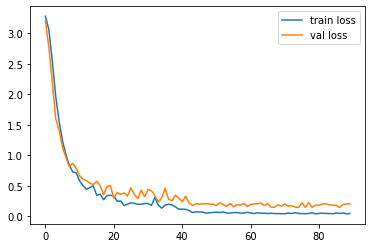

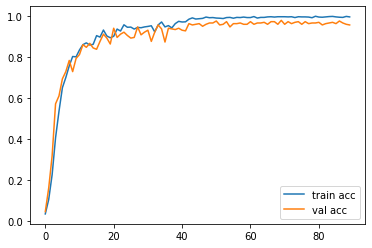

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

[[[147. 147. 147.]
  [135. 135. 135.]
  [140. 140. 140.]
  ...
  [138. 138. 138.]
  [137. 137. 137.]
  [138. 138. 138.]]

 [[129. 129. 129.]
  [143. 143. 143.]
  [139. 139. 139.]
  ...
  [148. 148. 148.]
  [137. 137. 137.]
  [134. 134. 134.]]

 [[148. 148. 148.]
  [116. 116. 116.]
  [112. 112. 112.]
  ...
  [137. 137. 137.]
  [139. 139. 139.]
  [136. 136. 136.]]

 ...

 [[140. 140. 140.]
  [140. 140. 140.]
  [139. 139. 139.]
  ...
  [141. 141. 141.]
  [141. 141. 141.]
  [141. 141. 141.]]

 [[141. 141. 141.]
  [142. 142. 142.]
  [142. 142. 142.]
  ...
  [141. 141. 141.]
  [141. 141. 141.]
  [141. 141. 141.]]

 [[140. 140. 140.]
  [140. 140. 140.]
  [140. 140. 140.]
  ...
  [141. 141. 141.]
  [141. 141. 141.]
  [141. 141. 141.]]]
(28, 28, 3)
1/1 [==============================] - 0s 15ms/step
c


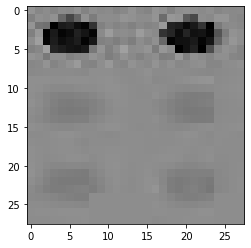

In [11]:
from tensorflow.keras.preprocessing import image
img=image.load_img('/content/drive/MyDrive/Personal/Main Project/Braille Dataset/c1.JPG3dim.jpg')

plt.imshow(img)

x=image.img_to_array(img)
print(x)

print(x.shape)

x=np.expand_dims(x,axis=0)
model.predict(x)

a=int(np.argmax(model.predict(x), axis=1))

print(chr(ord('`')+a+1))
